In [2]:
pip install osmnx geopandas shapely pandas requests tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade osmnx

Note: you may need to restart the kernel to use updated packages.


In [6]:
import osmnx as ox
import geopandas as gpd

# 替代 geometries_from_place 的方式
place = "Manchester, Greater Manchester, United Kingdom"

# 下载道路网络（只限机动车可行道路）
G = ox.graph_from_place(place, network_type='drive')

# 转换为 GeoDataFrame
nodes, edges = ox.graph_to_gdfs(G)

# 筛选出主干道和次干道
edges = edges[edges['highway'].isin(['primary', 'secondary'])]

# 可视化检查（可选）
print(edges.head())

# 保存为 shapefile
edges.to_file("/Users/sillyfish/Desktop/dissertation/data/manchester_roads_primary_secondary.shp")


                                                osmid    highway lanes  \
u      v          key                                                    
234984 3449204    0           [628628148, 1074295407]    primary     2   
       25423456   0    [1074301970, 4353083, 4353079]    primary     2   
643133 28889609   0                         165420776  secondary     2   
       30891124   0              [1005433650, 931013]  secondary     2   
643136 9257753667 0                         448796916  secondary     2   

                               maxspeed  oneway    ref reversed     length  \
u      v          key                                                        
234984 3449204    0    [30 mph, 20 mph]   False  A5067     True  59.613041   
       25423456   0              20 mph   False  A5067    False  64.232902   
643133 28889609   0              20 mph   False  B5117    False   9.049076   
       30891124   0              20 mph   False  B5117     True  71.888044   
643136 925775

In [8]:
import geopandas as gpd
from shapely.geometry import LineString, Point
import pandas as pd

# 读取前一步生成的道路数据
edges = gpd.read_file("/Users/sillyfish/Desktop/dissertation/data/manchester_roads_primary_secondary.shp")

sample_points = []
sample_id = 0

# 设定采样间距（单位：米）
distance = 50  

# 投影到 British National Grid 或 UTM，进行距离计算
edges_projected = edges.to_crs(epsg=27700)

for idx, row in edges_projected.iterrows():
    geom = row.geometry
    if isinstance(geom, LineString):
        length = geom.length
        for i in range(0, int(length), distance):
            point = geom.interpolate(i)
            sample_points.append({
                "id": sample_id,
                "geometry": point
            })
            sample_id += 1
    elif geom.geom_type == "MultiLineString":
        for part in geom:
            length = part.length
            for i in range(0, int(length), distance):
                point = part.interpolate(i)
                sample_points.append({
                    "id": sample_id,
                    "geometry": point
                })
                sample_id += 1

# 转换为 GeoDataFrame 并转回 WGS84 坐标系
gdf_points = gpd.GeoDataFrame(sample_points, crs="EPSG:27700")
gdf_points = gdf_points.to_crs(epsg=4326)

# 拆出经纬度列
gdf_points["lon"] = gdf_points.geometry.x
gdf_points["lat"] = gdf_points.geometry.y

# 保存为 GeoJSON 和 CSV
output_geojson = "/Users/sillyfish/Desktop/dissertation/data/manchester_sample_points.geojson"
output_csv = "/Users/sillyfish/Desktop/dissertation/data/manchester_sample_points.csv"

gdf_points.to_file(output_geojson, driver="GeoJSON")
gdf_points.drop(columns="geometry").to_csv(output_csv, index=False)

print(f"✅ 生成 {len(gdf_points)} 个采样点，已保存至：")
print(f"- GeoJSON: {output_geojson}")
print(f"- CSV: {output_csv}")


✅ 生成 3624 个采样点，已保存至：
- GeoJSON: /Users/sillyfish/Desktop/dissertation/data/manchester_sample_points.geojson
- CSV: /Users/sillyfish/Desktop/dissertation/data/manchester_sample_points.csv


In [10]:
import requests
import pandas as pd
import time
from tqdm import tqdm

# 读取采样点 CSV
points = pd.read_csv("/Users/sillyfish/Desktop/dissertation/data/manchester_sample_points.csv")

# Mapillary token
ACCESS_TOKEN = "MLY|24343329731940448|7790b136d6fad9823fc2ae78eadaee94"

# 输出保存路径
output_path = "/Users/sillyfish/Desktop/dissertation/data/mapillary_metadata.csv"

# API 基础路径
API_URL = "https://graph.mapillary.com/images"

# 存储结果
metadata = []

# 设置每次查询的搜索半径（单位：米）
search_radius = 50

print(f"开始查询 Mapillary 图像元数据（共 {len(points)} 个点）...")

for i, row in tqdm(points.iterrows(), total=len(points)):
    lat = row['lat']
    lon = row['lon']
    point_id = row['id']

    params = {
        "access_token": ACCESS_TOKEN,
        "fields": "id,geometry,computed_geometry,captured_at,compass_angle,thumb_1024_url",
        "closeto": f"{lon},{lat}",
        "radius": search_radius
    }

    try:
        response = requests.get(API_URL, params=params)
        if response.status_code == 200:
            data = response.json()
            if "data" in data and len(data["data"]) > 0:
                img = data["data"][0]
                metadata.append({
                    "id": point_id,
                    "lon": lon,
                    "lat": lat,
                    "image_key": img.get("id"),
                    "compass_angle": img.get("compass_angle"),
                    "capture_date": img.get("captured_at"),
                    "image_url": img.get("thumb_1024_url")
                })
        else:
            print(f"❌ 点 {point_id} 请求失败，状态码：{response.status_code}")
        time.sleep(0.2)  # 控制速率，避免被限速
    except Exception as e:
        print(f"❌ 点 {point_id} 请求出错：{e}")
        continue

# 保存为 CSV
df_out = pd.DataFrame(metadata)
df_out.to_csv(output_path, index=False)

print(f"\n✅ 成功获取 {len(df_out)} 个图像元数据，保存至：{output_path}")


开始查询 Mapillary 图像元数据（共 3624 个点）...


100%|███████████████████████████████████████| 3624/3624 [20:44<00:00,  2.91it/s]


✅ 成功获取 0 个图像元数据，保存至：/Users/sillyfish/Desktop/dissertation/data/mapillary_metadata.csv


字段名: Index(['dt_adcode', 'dt_name', 'ct_adcode', 'ct_name', 'pr_adcode', 'pr_name',
       'cn_adcode', 'cn_name', 'geometry'],
      dtype='object')
  dt_adcode dt_name ct_adcode ct_name pr_adcode pr_name cn_adcode  cn_name  \
0    110101     东城区    110100    北京城区    110000     北京市    100000  中华人民共和国   
1    110102     西城区    110100    北京城区    110000     北京市    100000  中华人民共和国   
2    110105     朝阳区    110100    北京城区    110000     北京市    100000  中华人民共和国   
3    110106     丰台区    110100    北京城区    110000     北京市    100000  中华人民共和国   
4    110107    石景山区    110100    北京城区    110000     北京市    100000  中华人民共和国   

                                            geometry  
0  POLYGON ((116.38766 39.96092, 116.38948 39.961...  
1  POLYGON ((116.39301 39.96916, 116.39235 39.968...  
2  MULTIPOLYGON (((116.44393 39.87442, 116.44412 ...  
3  POLYGON ((116.16577 39.77444, 116.16516 39.773...  
4  POLYGON ((116.15157 39.99344, 116.15341 39.992...  


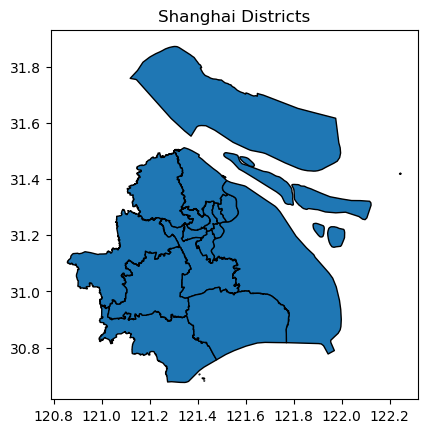

✅ 提取成功，已保存为：/Users/sillyfish/Desktop/dissertation/data/shanghai_district.shp


In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

# 设置路径
input_path = "/Users/sillyfish/Desktop/dissertation/data/china_district/district.shp"
output_path = "/Users/sillyfish/Desktop/dissertation/data/shanghai_district.shp"

# 读取全国区划边界
gdf = gpd.read_file(input_path)

# 查看字段名以确定哪一列包含“省份”或“城市”名称
print("字段名:", gdf.columns)
print(gdf.head())

# 筛选包含“上海”或“上海市”的记录（你可能需要根据字段名调整）
shanghai_gdf = gdf[gdf.apply(lambda row: "上海" in "".join(map(str, row)), axis=1)]

# 可视化检查
shanghai_gdf.plot(edgecolor='black')
plt.title("Shanghai Districts")
plt.show()

# 保存为新 shapefile
shanghai_gdf.to_file(output_path)

print(f"✅ 提取成功，已保存为：{output_path}")


In [18]:
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString
import os

# === 参数设置 ===
input_path = "/Users/sillyfish/Desktop/dissertation/data/shanghai_shp/gis_osm_roads_free_1.shp"
output_path = "/Users/sillyfish/Desktop/dissertation/data/shanghai_sample_points.geojson"
interval_m = 50  # 采样间隔（单位：米）

# === 读取道路数据 ===
roads = gpd.read_file(input_path)

# 投影为 UTM 51N（EPSG:32651，适用于上海）以便按米计算距离
roads_utm = roads.to_crs(epsg=32651)

# === 生成采样点 ===
all_points = []

for geom in roads_utm.geometry:
    if geom is None:
        continue
    lines = [geom] if isinstance(geom, LineString) else geom.geoms
    for line in lines:
        length = line.length
        for i in range(int(length // interval_m)):
            pt = line.interpolate(i * interval_m)
            all_points.append(pt)

# === 构建点 GeoDataFrame ===
points_gdf = gpd.GeoDataFrame(geometry=all_points, crs=roads_utm.crs)

# === 转回 WGS84 坐标系 ===
points_wgs84 = points_gdf.to_crs(epsg=4326)

# === 保存为 GeoJSON 文件（供百度街景使用） ===
points_wgs84.to_file(output_path, driver="GeoJSON")

print(f"✅ 成功生成 {len(points_wgs84)} 个采样点，文件保存至：\n{output_path}")


✅ 成功生成 893045 个采样点，文件保存至：
/Users/sillyfish/Desktop/dissertation/data/shanghai_sample_points.geojson


In [20]:
import geopandas as gpd

# 设置文件路径
geojson_path = "/Users/sillyfish/Desktop/dissertation/data/shanghai_sample_points.geojson"

# 读取 GeoJSON 文件
gdf = gpd.read_file(geojson_path)

# 打印前 5 行内容
print(gdf.head())


                     geometry
0  POINT (121.55715 31.26099)
1   POINT (121.55743 31.2606)
2  POINT (121.55771 31.26022)
3    POINT (121.558 31.25984)
4  POINT (121.55828 31.25947)


In [1]:
import geopandas as gpd
import pandas as pd

# 读取 GeoJSON 文件
geojson_path = "/Users/sillyfish/Desktop/dissertation/data/shanghai_sample_points.geojson"
gdf = gpd.read_file(geojson_path)

# 提取 WGS84 坐标（X=lon, Y=lat）
gdf["X"] = gdf.geometry.x
gdf["Y"] = gdf.geometry.y

# 只保留 X, Y 两列
df_coords = gdf[["X", "Y"]]

# 保存为 CSV 文件
csv_path = "/Users/sillyfish/Desktop/dissertation/data/shanghai_sample_points.csv"
df_coords.to_csv(csv_path, index=False)

print(f"✅ 提取完成，共 {len(df_coords)} 个点，保存至：{csv_path}")


✅ 提取完成，共 893045 个点，保存至：/Users/sillyfish/Desktop/dissertation/data/shanghai_sample_points.csv


In [3]:
import geopandas as gpd

# 读取原始道路 shapefile
input_path = "/Users/sillyfish/Desktop/dissertation/data/shanghai_shp/gis_osm_roads_free_1.shp"
gdf = gpd.read_file(input_path)

# 打印字段名，确认包含的道路类型字段
print("字段名：", gdf.columns)

# 查看所有唯一的道路等级分类字段值（如 fclass 或 highway）
if 'fclass' in gdf.columns:
    print("\n'fclass' 字段分类：")
    print(gdf['fclass'].value_counts())
elif 'highway' in gdf.columns:
    print("\n'highway' 字段分类：")
    print(gdf['highway'].value_counts())
else:
    print("\n❌ 没有发现常用的道路分类字段（fclass 或 highway），请手动检查字段名。")


字段名： Index(['osm_id', 'code', 'fclass', 'name', 'ref', 'oneway', 'maxspeed',
       'layer', 'bridge', 'tunnel', 'geometry'],
      dtype='object')

'fclass' 字段分类：
fclass
residential       41166
service           37162
tertiary          20585
footway           18842
secondary         17020
unclassified      16438
primary           13301
track              5269
motorway           4387
motorway_link      4056
trunk              3114
cycleway           2784
path               2221
trunk_link         1882
pedestrian         1603
living_street      1482
steps              1005
primary_link        738
secondary_link      290
tertiary_link       232
track_grade1        122
track_grade2         71
unknown              41
track_grade3         20
bridleway            15
track_grade5          1
Name: count, dtype: int64


In [5]:
import geopandas as gpd

# 输入路径和输出路径
input_path = "/Users/sillyfish/Desktop/dissertation/data/shanghai_shp/gis_osm_roads_free_1.shp"
output_path = "/Users/sillyfish/Desktop/dissertation/data/shanghai_shp/filtered_major_roads.shp"

# 读取原始道路数据
gdf = gpd.read_file(input_path)

# 定义主干道及连接道路类型
major_road_classes = [
    "primary", "secondary", "tertiary",
    "primary_link", "secondary_link", "tertiary_link"
]

# 筛选出这些类型
gdf_filtered = gdf[gdf['fclass'].isin(major_road_classes)]

# 保存筛选后的道路为新的 shapefile
gdf_filtered.to_file(output_path)

print(f"✅ 已成功筛选主要道路，共 {len(gdf_filtered)} 条，并保存至：{output_path}")


✅ 已成功筛选主要道路，共 52166 条，并保存至：/Users/sillyfish/Desktop/dissertation/data/shanghai_shp/filtered_major_roads.shp


In [1]:
import geopandas as gpd
import os

# 原始 GeoJSON 路径
geojson_path = "/Users/sillyfish/Desktop/dissertation/data/shanghai_sample_points.geojson"

# 读取 GeoJSON 文件
gdf = gpd.read_file(geojson_path)

# 提取经纬度坐标
gdf["lon"] = gdf.geometry.x
gdf["lat"] = gdf.geometry.y

# 生成新的 DataFrame，仅包含经纬度列
df = gdf[["lon", "lat"]]

# 输出路径（保存到同一目录下）
csv_path = os.path.join(os.path.dirname(geojson_path), "shanghai_sample_points.csv")

# 保存为 CSV 文件（不带索引）
df.to_csv(csv_path, index=False)

print(f"✅ 已成功保存为 CSV 文件：{csv_path}")


✅ 已成功保存为 CSV 文件：/Users/sillyfish/Desktop/dissertation/data/shanghai_sample_points.csv


In [7]:
import pandas as pd
import requests
import time

# 百度地理编码函数（返回 BD-09 经纬度）
def geocode_baidu(address, ak):
    base_url = "http://api.map.baidu.com/geocoding/v3/"
    params = {
        "address": f"上海市{address}",
        "output": "json",
        "ak": ak
    }
    response = requests.get(base_url, params=params)
    res = response.json()
    if res.get("status") == 0:
        lng = res["result"]["location"]["lng"]
        lat = res["result"]["location"]["lat"]
        return pd.Series([lat, lng])
    else:
        return pd.Series([None, None])

# 读取数据
file_path = "/Users/sillyfish/Desktop/dissertation/historicalbuildings_all.xlsx"
df = pd.read_excel(file_path)
df.columns = [c.strip().upper() for c in df.columns]
df = df.rename(columns={"NAME": "name", "ADRESS": "address"})

# 设置你的百度地图 AK
ak = "MlZltzgkKs9azTjwzHke5MMTg2HClDBo"

# 对每条地址调用地理编码 API（加入 sleep 防限速）
results = df["address"].apply(lambda x: geocode_baidu(x, ak) if pd.notnull(x) else pd.Series([None, None]))
df[["lat_bd09", "lon_bd09"]] = results

# 输出结果
# 替代保存为 csv 的方式
output_path_xlsx = "/Users/sillyfish/Desktop/dissertation/historicalbuildings_with_bd09_coords.xlsx"
df.to_excel(output_path_xlsx, index=False)
print(f"✅ Excel 已保存：{output_path_xlsx}")



✅ Excel 已保存：/Users/sillyfish/Desktop/dissertation/historicalbuildings_with_bd09_coords.xlsx


In [13]:
import pandas as pd
import numpy as np

# BD09 → GCJ02
def bd09_to_gcj02(bd_lon, bd_lat):
    x = bd_lon - 0.0065
    y = bd_lat - 0.006
    z = np.sqrt(x * x + y * y) - 0.00002 * np.sin(y * np.pi)
    theta = np.arctan2(y, x) - 0.000003 * np.cos(x * np.pi)
    gg_lng = z * np.cos(theta)
    gg_lat = z * np.sin(theta)
    return gg_lng, gg_lat

# GCJ02 → WGS84
def gcj02_to_wgs84(lng, lat):
    a = 6378245.0
    ee = 0.00669342162296594323

    def transform_lat(x, y):
        ret = -100.0 + 2.0 * x + 3.0 * y + 0.2 * y * y + \
              0.1 * x * y + 0.2 * np.sqrt(np.abs(x))
        ret += (20.0 * np.sin(6.0 * x * np.pi) + 20.0 *
                np.sin(2.0 * x * np.pi)) * 2.0 / 3.0
        ret += (20.0 * np.sin(y * np.pi) + 40.0 *
                np.sin(y / 3.0 * np.pi)) * 2.0 / 3.0
        ret += (160.0 * np.sin(y / 12.0 * np.pi) + 320 *
                np.sin(y * np.pi / 30.0)) * 2.0 / 3.0
        return ret

    def transform_lng(x, y):
        ret = 300.0 + x + 2.0 * y + 0.1 * x * x + \
              0.1 * x * y + 0.1 * np.sqrt(np.abs(x))
        ret += (20.0 * np.sin(6.0 * x * np.pi) + 20.0 *
                np.sin(2.0 * x * np.pi)) * 2.0 / 3.0
        ret += (20.0 * np.sin(x * np.pi) + 40.0 *
                np.sin(x / 3.0 * np.pi)) * 2.0 / 3.0
        ret += (150.0 * np.sin(x / 12.0 * np.pi) + 300.0 *
                np.sin(x / 30.0 * np.pi)) * 2.0 / 3.0
        return ret

    dlat = transform_lat(lng - 105.0, lat - 35.0)
    dlng = transform_lng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * np.pi
    magic = np.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = np.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) /
           (magic * sqrtmagic) * np.pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * np.cos(radlat) * np.pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return lng * 2 - mglng, lat * 2 - mglat

# 文件路径
input_path = "/Users/sillyfish/Desktop/dissertation/historicalbuildings_with_bd09_coords.xlsx"
df = pd.read_excel(input_path)  # ← 正确读取 .xlsx 文件

# BD-09 → GCJ-02
df[["lon_gcj", "lat_gcj"]] = df.apply(
    lambda row: pd.Series(bd09_to_gcj02(row["lon_bd09"], row["lat_bd09"])), axis=1)

# GCJ-02 → WGS84
df[["lon_wgs84", "lat_wgs84"]] = df.apply(
    lambda row: pd.Series(gcj02_to_wgs84(row["lon_gcj"], row["lat_gcj"])), axis=1)

output_path = "/Users/sillyfish/Desktop/dissertation/historicalbuildings_with_wgs84.xlsx"
df.to_excel(output_path, index=False)
print(f"✅ 坐标转换完成，已保存到：{output_path}")



✅ 坐标转换完成，已保存到：/Users/sillyfish/Desktop/dissertation/historicalbuildings_with_wgs84.xlsx


In [27]:
import pandas as pd
import requests
import time

# 百度 API 密钥
BAIDU_AK = "MlZltzgkKs9azTjwzHke5MMTg2HClDBo"

# 输入输出路径
input_path = "/Users/sillyfish/Desktop/dissertation/historicalbuildings_with_bd09_coords.xlsx"
output_path = "/Users/sillyfish/Desktop/dissertation/historicalbuildings_with_bd09mc.xlsx"

# 读取原始数据
df = pd.read_excel(input_path)
assert "lat_bd09" in df.columns and "lon_bd09" in df.columns, "缺少 lat_bd09 或 lon_bd09 列"

# 批量坐标转换
converted_coords = []
batch_size = 100

for i in range(0, len(df), batch_size):
    batch = df.iloc[i:i+batch_size].copy().reset_index(drop=True)
    
    # 筛选合法坐标
    valid_rows = batch.dropna(subset=["lat_bd09", "lon_bd09"])
    valid_rows = valid_rows[(valid_rows["lat_bd09"].apply(lambda x: isinstance(x, (int, float)))) &
                            (valid_rows["lon_bd09"].apply(lambda x: isinstance(x, (int, float))))]

    coords = ";".join(f"{lon},{lat}" for lon, lat in zip(valid_rows["lon_bd09"], valid_rows["lat_bd09"]))
    
    if not coords:
        print(f"⚠️ Batch {i} 无有效坐标，跳过")
        converted_coords.extend([[None, None]] * len(batch))
        continue

    url = f"http://api.map.baidu.com/geoconv/v1/?coords={coords}&from=5&to=6&ak={BAIDU_AK}"
    response = requests.get(url)
    data = response.json()

    if data["status"] != 0:
        print(f"❌ 转换失败: batch {i} status: {data['status']}, message: {data.get('message', '未知错误')}")
        converted_coords.extend([[None, None]] * len(batch))
    else:
        result_iter = iter([[res["x"], res["y"]] for res in data["result"]])
        for _, row in batch.iterrows():
            if pd.isna(row["lat_bd09"]) or pd.isna(row["lon_bd09"]):
                converted_coords.append([None, None])
            else:
                try:
                    converted_coords.append(next(result_iter))
                except StopIteration:
                    converted_coords.append([None, None])
    
    time.sleep(1)  # 防止频率限制

# 添加转换结果
df[["x_bd09mc", "y_bd09mc"]] = pd.DataFrame(converted_coords, columns=["x_bd09mc", "y_bd09mc"])

# 保存为 Excel
df.to_excel(output_path, index=False)
print(f"✅ 坐标转换完成，文件已保存至：{output_path}")


✅ 坐标转换完成，文件已保存至：/Users/sillyfish/Desktop/dissertation/historicalbuildings_with_bd09mc.xlsx


In [33]:
import os
import time
import json
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from math import ceil

# 配置参数
input_path = "/Users/sillyfish/Desktop/dissertation/historicalbuildings_with_bd09mc.xlsx"
output_base = "/Users/sillyfish/Desktop/dissertation/streetview_images_single_angle"
zoom = 3
delay = 2  # 秒

# 创建主输出目录
os.makedirs(output_base, exist_ok=True)

def getImageID(x, y):
    url = f"https://mapsv1.bdimg.com/?qt=qsdata&x={x}&y={y}"
    resp = requests.get(url)
    data = json.loads(resp.text)
    if "content" in data and "id" in data["content"]:
        return data["content"]["id"]
    else:
        raise ValueError("❌ 获取图像ID失败")

def getImageBytesList(sid, z=3):
    if z == 2:
        xrange, yrange = 1, 2
    elif z == 3:
        xrange, yrange = 2, 4
    elif z == 1:
        xrange, yrange = 1, 1
    elif z == 4:
        xrange, yrange = 4, 8
    else:
        raise ValueError("❌ 不支持的 zoom 等级")

    imgBytes = []
    for x in range(xrange):
        for y in range(yrange):
            url = f"https://mapsv1.bdimg.com/?qt=pdata&sid={sid}&pos={x}_{y}&z={z}&from=PC"
            b = requests.get(url).content
            imgBytes.append(b)
    return imgBytes

def mergeImage(imgBytesList, zoom):
    imgNumPerRow = {1: 1, 2: 2, 3: 4, 4: 8}[zoom]
    imgList = [Image.open(BytesIO(b)) for b in imgBytesList]
    w, h = imgList[0].size
    rowNum = ceil(len(imgList) / imgNumPerRow)
    merged = Image.new("RGB", (w * imgNumPerRow, h * rowNum))
    for i, img in enumerate(imgList):
        x = i // imgNumPerRow
        y = i % imgNumPerRow
        merged.paste(img, (y * w, x * h))
    return merged

# 加载点位
df = pd.read_excel(input_path)
failures = []

# 遍历每个点
for idx, row in df.iterrows():
    name = str(row["name"]).strip().replace("/", "_").replace("\\", "_")
    x = row.get("x_bd09mc")
    y = row.get("y_bd09mc")

    if pd.isna(x) or pd.isna(y):
        print(f"⚠️ 坐标缺失: {name}")
        failures.append((name, "无坐标"))
        continue

    folder = os.path.join(output_base, f"{idx:04d}_{name}")
    os.makedirs(folder, exist_ok=True)
    save_path = os.path.join(folder, "streetview.jpg")

    print(f"📍 下载: {name} @ ({x}, {y})")

    try:
        sid = getImageID(x, y)
        imgBytes = getImageBytesList(sid, zoom)
        merged = mergeImage(imgBytes, zoom)
        merged.save(save_path)
        print(f"✅ 完成: {name}")
    except Exception as e:
        print(f"❌ 失败: {name} -> {e}")
        failures.append((name, str(e)))

    time.sleep(delay)

# 保存失败记录
if failures:
    fail_df = pd.DataFrame(failures, columns=["name", "reason"])
    fail_path = os.path.join(output_base, "download_failures.csv")
    fail_df.to_csv(fail_path, index=False)
    print(f"\n⚠️ 下载失败 {len(failures)} 项，详情见：{fail_path}")
else:
    print("\n🎉 所有图像下载成功！")


📍 下载: 中国太平洋保险公司、上海银行 @ (13525243.99999999, 3641487.982846188)
✅ 完成: 中国太平洋保险公司、上海银行
📍 下载: 东风饭店 @ (13525191.25999999, 3641532.932852173)
✅ 完成: 东风饭店
📍 下载: 浦东发展银行 @ (13525076.78999999, 3641760.307882511)
✅ 完成: 浦东发展银行
📍 下载: 上海海关 @ (13525077.36999999, 3641899.382901128)
✅ 完成: 上海海关
📍 下载: 和平饭店南楼 @ (13525030.05999999, 3642168.282937259)
✅ 完成: 和平饭店南楼
📍 下载: 和平饭店北楼 @ (13525057.72, 3642231.062945722)
✅ 完成: 和平饭店北楼
📍 下载: 中国银行上海分行 @ (13525078.66, 3642319.692957681)
✅ 完成: 中国银行上海分行
📍 下载: 市对外贸易局 @ (13525089.58999999, 3642380.152965849)
✅ 完成: 市对外贸易局
📍 下载: 光大银行 @ (13525066.29, 3642513.622983916)
✅ 完成: 光大银行
📍 下载: 大世界游乐场 @ (13523898.46999999, 3640828.382758962)
✅ 完成: 大世界游乐场
📍 下载: 青年会宾馆 @ (13523912.94999999, 3640708.022743159)
✅ 完成: 青年会宾馆
📍 下载: 上海音乐厅 @ (13523737.09999999, 3640556.642723338)
✅ 完成: 上海音乐厅
📍 下载: 国际饭店 @ (13523054.98999999, 3641530.262851816)
✅ 完成: 国际饭店
📍 下载: 上海市体育总会市体委 @ (13523050.42999999, 3641538.912852968)
✅ 完成: 上海市体育总会市体委
📍 下载: 金门大酒店 @ (13523118.83999999, 3641597.012860708)
✅ 完成: 金门大酒店
📍 下载: 大

KeyboardInterrupt: 

In [35]:
import os
import time
import json
import math
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from math import ceil, cos, sin

# 路径配置
input_path = "/Users/sillyfish/Desktop/dissertation/historicalbuildings_with_bd09mc.xlsx"
output_base = "/Users/sillyfish/Desktop/dissertation/streetview_images_with_50m_samples"
zoom = 3
delay = 1.5  # 秒
sample_distance = 50  # 单位：米
sample_count = 8  # 每个点位方向上的采样点数量

# 百度墨卡托坐标：每米等于多少单位
# 百度墨卡托大致为每米 1 个单位，但精确转换按比例缩放
meter_to_bd09mc = 1  # 你可以设置为0.9或1.2做微调

# 创建输出目录
os.makedirs(output_base, exist_ok=True)

# 获取图像 ID
def getImageID(x, y):
    url = f"https://mapsv1.bdimg.com/?qt=qsdata&x={x}&y={y}"
    resp = requests.get(url)
    data = json.loads(resp.text)
    if "content" in data and "id" in data["content"]:
        return data["content"]["id"]
    else:
        raise ValueError("❌ 获取图像ID失败")

# 获取图像字节流
def getImageBytesList(sid, z=3):
    if z == 2:
        xrange, yrange = 1, 2
    elif z == 3:
        xrange, yrange = 2, 4
    elif z == 1:
        xrange, yrange = 1, 1
    elif z == 4:
        xrange, yrange = 4, 8
    else:
        raise ValueError("❌ 不支持的 zoom 等级")

    imgBytes = []
    for x in range(xrange):
        for y in range(yrange):
            url = f"https://mapsv1.bdimg.com/?qt=pdata&sid={sid}&pos={x}_{y}&z={z}&from=PC"
            b = requests.get(url).content
            imgBytes.append(b)
    return imgBytes

# 合并图像
def mergeImage(imgBytesList, zoom):
    imgNumPerRow = {1: 1, 2: 2, 3: 4, 4: 8}[zoom]
    imgList = [Image.open(BytesIO(b)) for b in imgBytesList]
    w, h = imgList[0].size
    rowNum = ceil(len(imgList) / imgNumPerRow)
    merged = Image.new("RGB", (w * imgNumPerRow, h * rowNum))
    for i, img in enumerate(imgList):
        x = i // imgNumPerRow
        y = i % imgNumPerRow
        merged.paste(img, (y * w, x * h))
    return merged

# 生成圆周上采样点
def generate_circle_samples(x, y, r, n):
    angle_step = 2 * math.pi / n
    return [
        (x + r * cos(i * angle_step), y + r * sin(i * angle_step))
        for i in range(n)
    ]

# 加载点位
df = pd.read_excel(input_path)
failures = []

# 遍历每个点
for idx, row in df.iterrows():
    name = str(row["name"]).strip().replace("/", "_").replace("\\", "_")
    x0 = row.get("x_bd09mc")
    y0 = row.get("y_bd09mc")

    if pd.isna(x0) or pd.isna(y0):
        print(f"⚠️ 坐标缺失: {name}")
        failures.append((name, "无坐标"))
        continue

    folder = os.path.join(output_base, f"{idx:04d}_{name}")
    os.makedirs(folder, exist_ok=True)

    # 包括原始点和周边采样点
    points = [(x0, y0)] + generate_circle_samples(x0, y0, sample_distance * meter_to_bd09mc, sample_count)

    for j, (x, y) in enumerate(points):
        try:
            print(f"📍 下载: {name} - 点{j} @ ({x:.2f}, {y:.2f})")
            sid = getImageID(x, y)
            imgBytes = getImageBytesList(sid, zoom)
            merged = mergeImage(imgBytes, zoom)
            img_path = os.path.join(folder, f"point_{j:02d}.jpg")
            merged.save(img_path)
            time.sleep(delay)
        except Exception as e:
            print(f"❌ 失败: {name} 点{j} -> {e}")
            failures.append((f"{name}_point{j}", str(e)))

# 保存失败记录
if failures:
    fail_df = pd.DataFrame(failures, columns=["name", "reason"])
    fail_path = os.path.join(output_base, "download_failures.csv")
    fail_df.to_csv(fail_path, index=False)
    print(f"\n⚠️ 下载失败 {len(failures)} 项，详情见：{fail_path}")
else:
    print("\n🎉 所有图像下载成功！")


📍 下载: 中国太平洋保险公司、上海银行 - 点0 @ (13525244.00, 3641487.98)
📍 下载: 中国太平洋保险公司、上海银行 - 点1 @ (13525294.00, 3641487.98)
📍 下载: 中国太平洋保险公司、上海银行 - 点2 @ (13525279.36, 3641523.34)
📍 下载: 中国太平洋保险公司、上海银行 - 点3 @ (13525244.00, 3641537.98)
📍 下载: 中国太平洋保险公司、上海银行 - 点4 @ (13525208.64, 3641523.34)
📍 下载: 中国太平洋保险公司、上海银行 - 点5 @ (13525194.00, 3641487.98)
📍 下载: 中国太平洋保险公司、上海银行 - 点6 @ (13525208.64, 3641452.63)
📍 下载: 中国太平洋保险公司、上海银行 - 点7 @ (13525244.00, 3641437.98)
📍 下载: 中国太平洋保险公司、上海银行 - 点8 @ (13525279.36, 3641452.63)
📍 下载: 东风饭店 - 点0 @ (13525191.26, 3641532.93)
📍 下载: 东风饭店 - 点1 @ (13525241.26, 3641532.93)
📍 下载: 东风饭店 - 点2 @ (13525226.62, 3641568.29)
📍 下载: 东风饭店 - 点3 @ (13525191.26, 3641582.93)
📍 下载: 东风饭店 - 点4 @ (13525155.90, 3641568.29)
📍 下载: 东风饭店 - 点5 @ (13525141.26, 3641532.93)
📍 下载: 东风饭店 - 点6 @ (13525155.90, 3641497.58)
📍 下载: 东风饭店 - 点7 @ (13525191.26, 3641482.93)
📍 下载: 东风饭店 - 点8 @ (13525226.62, 3641497.58)
📍 下载: 浦东发展银行 - 点0 @ (13525076.79, 3641760.31)
📍 下载: 浦东发展银行 - 点1 @ (13525126.79, 3641760.31)
📍 下载: 浦东发展银行 - 点2 @ (13525

KeyboardInterrupt: 

In [1]:
import pandas as pd
import math

# 读取数据
input_path = "/Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_wgs84.xlsx"
df = pd.read_excel(input_path)

# 坐标转换函数（WGS84 → GCJ02）
def wgs84_to_gcj02(lon, lat):
    def out_of_china(lon, lat):
        return not (73.66 < lon < 135.05 and 3.86 < lat < 53.55)

    def transform_lat(x, y):
        ret = -100.0 + 2.0 * x + 3.0 * y + 0.2 * y * y + \
              0.1 * x * y + 0.2 * math.sqrt(abs(x))
        ret += (20.0 * math.sin(6.0 * x * math.pi) +
                20.0 * math.sin(2.0 * x * math.pi)) * 2.0 / 3.0
        ret += (20.0 * math.sin(y * math.pi) +
                40.0 * math.sin(y / 3.0 * math.pi)) * 2.0 / 3.0
        ret += (160.0 * math.sin(y / 12.0 * math.pi) +
                320 * math.sin(y * math.pi / 30.0)) * 2.0 / 3.0
        return ret

    def transform_lon(x, y):
        ret = 300.0 + x + 2.0 * y + 0.1 * x * x + \
              0.1 * x * y + 0.1 * math.sqrt(abs(x))
        ret += (20.0 * math.sin(6.0 * x * math.pi) +
                20.0 * math.sin(2.0 * x * math.pi)) * 2.0 / 3.0
        ret += (20.0 * math.sin(x * math.pi) +
                40.0 * math.sin(x / 3.0 * math.pi)) * 2.0 / 3.0
        ret += (150.0 * math.sin(x / 12.0 * math.pi) +
                300.0 * math.sin(x / 30.0 * math.pi)) * 2.0 / 3.0
        return ret

    if out_of_china(lon, lat):
        return lon, lat
    else:
        a = 6378245.0
        ee = 0.00669342162296594323
        dlat = transform_lat(lon - 105.0, lat - 35.0)
        dlon = transform_lon(lon - 105.0, lat - 35.0)
        radlat = lat / 180.0 * math.pi
        magic = math.sin(radlat)
        magic = 1 - ee * magic * magic
        sqrtmagic = math.sqrt(magic)
        dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * math.pi)
        dlon = (dlon * 180.0) / (a / sqrtmagic * math.cos(radlat) * math.pi)
        mglat = lat + dlat
        mglon = lon + dlon
        return mglon, mglat

# 批量转换
gcj_coords = df.apply(lambda row: wgs84_to_gcj02(row['lon_wgs84'], row['lat_wgs84']), axis=1)
df['lon_gcj'], df['lat_gcj'] = zip(*gcj_coords)

# 保存结果
output_path = "/Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_gcj02.xlsx"
df.to_excel(output_path, index=False)
print("✅ GCJ-02 坐标转换完成，结果保存至：", output_path)


✅ GCJ-02 坐标转换完成，结果保存至： /Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_gcj02.xlsx


In [17]:
import pandas as pd
import os

# 参数配置
api_key = "221476f962ded3b787b068264fa8c547"  # ✅ ← 替换为你的真实 key
input_path = "/Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_gcj02.xlsx"
output_dir = "/Users/sillyfish/Desktop/dissertation/heatmap_html"

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 读取坐标数据
df = pd.read_excel(input_path)

# HTML 模板（注意缩进和双大括号的 JS 语法）
html_template = """<!DOCTYPE html>
<html>
<head>
  <meta charset="utf-8">
  <title>热力图_{index}</title>
  <script src="https://webapi.amap.com/maps?v=2.0&key={key}"></script>
  <script src="https://webapi.amap.com/maps?v=2.0&plugin=AMap.HeatMap"></script>
</head>
<body>
<div id="container" style="width:800px; height:800px;"></div>
<script>
  var map = new AMap.Map('container', {{
    zoom: 18,
    center: [{lon}, {lat}],
    resizeEnable: true
  }});

  var heatmapData = [{{"lng": {lon}, "lat": {lat}, "count": 100}}];

  AMap.plugin(["AMap.HeatMap"], function () {{
    var heatmap = new AMap.HeatMap(map, {{
      radius: 130,
      opacity: [0, 0.8],
      gradient: {{0.5: 'blue', 0.65: 'lime', 0.85: 'orange', 1.0: 'red'}}
    }});
    heatmap.setDataSet({{
      data: heatmapData,
      max: 100
    }});
  }});
</script>
</body>
</html>
"""

# 批量生成 HTML 文件
for idx, row in df.iterrows():
    lat = row['lat_gcj']
    lon = row['lon_gcj']
    html_content = html_template.format(index=idx + 1, key=api_key, lon=lon, lat=lat)
    filename = os.path.join(output_dir, f"heatmap_{idx+1:04d}.html")
    with open(filename, "w", encoding="utf-8") as f:
        f.write(html_content)

print(f"✅ 共生成 {len(df)} 个 HTML 热力图文件，保存于：{output_dir}")


✅ 共生成 1058 个 HTML 热力图文件，保存于：/Users/sillyfish/Desktop/dissertation/heatmap_html


In [21]:
import pandas as pd
import os

# 配置参数
api_key = "221476f962ded3b787b068264fa8c547"  # ✅ 替换为你自己的 Key
input_path = "/Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_gcj02.xlsx"
output_dir = "/Users/sillyfish/Desktop/dissertation/real_heatmap_html"
os.makedirs(output_dir, exist_ok=True)

# 加载数据
df = pd.read_excel(input_path)

# 高德真实热力图 HTML 模板（无需自定义热力点！）
html_template = """<!DOCTYPE html>
<html>
<head>
  <meta charset="utf-8">
  <title>Real Heatmap_{index}</title>
  <script src="https://webapi.amap.com/maps?v=2.0&key={key}"></script>
  <script src="https://webapi.amap.com/maps?v=2.0&plugin=AMap.HeatMap"></script>
</head>
<body>
<div id="container" style="width:800px; height:800px;"></div>
<script>
  var map = new AMap.Map('container', {{
    zoom: 18,
    center: [{lon}, {lat}],
    resizeEnable: true
  }});

  AMap.plugin(["AMap.HeatMap"], function () {{
    new AMap.HeatMap(map);  // 👈 加载真实热力图瓦片层
  }});
</script>
</body>
</html>
"""

# 批量生成 HTML 页面
for idx, row in df.iterrows():
    lat = row['lat_gcj']
    lon = row['lon_gcj']
    html = html_template.format(index=idx+1, key=api_key, lon=lon, lat=lat)
    filename = os.path.join(output_dir, f"heatmap_{idx+1:04d}.html")
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(html)

print(f"✅ 已生成 {len(df)} 个 HTML 文件，路径：{output_dir}")


✅ 已生成 1058 个 HTML 文件，路径：/Users/sillyfish/Desktop/dissertation/real_heatmap_html


In [3]:
import os
import time
import json
import math
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from math import ceil, cos, sin

# === 路径配置 ===
input_path = "/Users/sillyfish/Desktop/dissertation/DATA/historical_building/historicalbuildings_with_bd09mc.xlsx"
output_base = "/Users/sillyfish/Desktop/dissertation/streetview_images_with_50m_samples"
zoom = 3
delay = 1.5  # 秒
sample_distance = 50  # 米
sample_count = 8  # 圆周采样点数
meter_to_bd09mc = 1  # 墨卡托坐标单位换算

# === 创建输出目录 ===
os.makedirs(output_base, exist_ok=True)

# === 获取图像 ID ===
def getImageID(x, y):
    url = f"https://mapsv1.bdimg.com/?qt=qsdata&x={x}&y={y}"
    resp = requests.get(url)
    data = json.loads(resp.text)
    if "content" in data and "id" in data["content"]:
        return data["content"]["id"]
    else:
        raise ValueError("❌ 获取图像ID失败")

# === 获取图像字节流 ===
def getImageBytesList(sid, z=3):
    if z == 2:
        xrange, yrange = 1, 2
    elif z == 3:
        xrange, yrange = 2, 4
    elif z == 1:
        xrange, yrange = 1, 1
    elif z == 4:
        xrange, yrange = 4, 8
    else:
        raise ValueError("❌ 不支持的 zoom 等级")

    imgBytes = []
    for x in range(xrange):
        for y in range(yrange):
            url = f"https://mapsv1.bdimg.com/?qt=pdata&sid={sid}&pos={x}_{y}&z={z}&from=PC"
            b = requests.get(url).content
            imgBytes.append(b)
    return imgBytes

# === 合并图像块为大图 ===
def mergeImage(imgBytesList, zoom):
    imgNumPerRow = {1: 1, 2: 2, 3: 4, 4: 8}[zoom]
    imgList = [Image.open(BytesIO(b)) for b in imgBytesList]
    w, h = imgList[0].size
    rowNum = ceil(len(imgList) / imgNumPerRow)
    merged = Image.new("RGB", (w * imgNumPerRow, h * rowNum))
    for i, img in enumerate(imgList):
        x = i // imgNumPerRow
        y = i % imgNumPerRow
        merged.paste(img, (y * w, x * h))
    return merged

# === 生成圆周上的采样点 ===
def generate_circle_samples(x, y, r, n):
    angle_step = 2 * math.pi / n
    return [
        (x + r * cos(i * angle_step), y + r * sin(i * angle_step))
        for i in range(n)
    ]

# === 加载 Excel 数据 ===
df = pd.read_excel(input_path)
failures = []

# === 仅爬取第 531 到 544 行的数据（即索引530–543） ===
start_idx = 530
end_idx = 544
for idx, row in df.iloc[start_idx:end_idx].iterrows():
    name = str(row["name"]).strip().replace("/", "_").replace("\\", "_")
    x0 = row.get("x_bd09mc")
    y0 = row.get("y_bd09mc")

    if pd.isna(x0) or pd.isna(y0):
        print(f"⚠️ 坐标缺失: {name}")
        failures.append((name, "无坐标"))
        continue

    folder = os.path.join(output_base, f"{idx:04d}_{name}")
    os.makedirs(folder, exist_ok=True)

    # 包括原始点和周边 8 个采样点
    points = [(x0, y0)] + generate_circle_samples(
        x0, y0, sample_distance * meter_to_bd09mc, sample_count
    )

    for j, (x, y) in enumerate(points):
        try:
            print(f"📍 下载: {name} - 点{j} @ ({x:.2f}, {y:.2f})")
            sid = getImageID(x, y)
            imgBytes = getImageBytesList(sid, zoom)
            merged = mergeImage(imgBytes, zoom)
            img_path = os.path.join(folder, f"point_{j:02d}.jpg")
            merged.save(img_path)
            time.sleep(delay)
        except Exception as e:
            print(f"❌ 失败: {name} 点{j} -> {e}")
            failures.append((f"{name}_point{j}", str(e)))

# === 保存失败记录 ===
if failures:
    fail_df = pd.DataFrame(failures, columns=["name", "reason"])
    fail_path = os.path.join(output_base, "download_failures.csv")
    fail_df.to_csv(fail_path, index=False)
    print(f"\n⚠️ 下载失败 {len(failures)} 项，详情见：{fail_path}")
else:
    print("\n🎉 所有图像下载成功！")


📍 下载: 市建委老干部活动中心 - 点0 @ (13520163.65, 3637565.74)
📍 下载: 市建委老干部活动中心 - 点1 @ (13520213.65, 3637565.74)
❌ 失败: 市建委老干部活动中心 点1 -> ('Connection broken: IncompleteRead(32378 bytes read, 9348 more expected)', IncompleteRead(32378 bytes read, 9348 more expected))
📍 下载: 市建委老干部活动中心 - 点2 @ (13520199.01, 3637601.10)
📍 下载: 市建委老干部活动中心 - 点3 @ (13520163.65, 3637615.74)
📍 下载: 市建委老干部活动中心 - 点4 @ (13520128.29, 3637601.10)
📍 下载: 市建委老干部活动中心 - 点5 @ (13520113.65, 3637565.74)
📍 下载: 市建委老干部活动中心 - 点6 @ (13520128.29, 3637530.39)
📍 下载: 市建委老干部活动中心 - 点7 @ (13520163.65, 3637515.74)
📍 下载: 市建委老干部活动中心 - 点8 @ (13520199.01, 3637530.39)
📍 下载: 建安公寓 - 点0 @ (13520224.09, 3637352.06)
📍 下载: 建安公寓 - 点1 @ (13520274.09, 3637352.06)
📍 下载: 建安公寓 - 点2 @ (13520259.45, 3637387.42)
📍 下载: 建安公寓 - 点3 @ (13520224.09, 3637402.06)
📍 下载: 建安公寓 - 点4 @ (13520188.73, 3637387.42)
📍 下载: 建安公寓 - 点5 @ (13520174.09, 3637352.06)
📍 下载: 建安公寓 - 点6 @ (13520188.73, 3637316.71)
📍 下载: 建安公寓 - 点7 @ (13520224.09, 3637302.06)
📍 下载: 建安公寓 - 点8 @ (13520259.45, 3637316.71)
📍

In [7]:
import os
import cv2
from pathlib import Path

input_root = "/Users/sillyfish/Desktop/dissertation/DATA/streetview_images_with_50m_samples"
output_root = "/Users/sillyfish/Desktop/dissertation/DATA/streetview_images_processed"
target_size = (512, 512)
blur_threshold = 100

def is_blurry(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var() < blur_threshold

def process_image(img_path, save_path):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"❌ 无法读取图像：{img_path}")
        return
    if is_blurry(img):
        print(f"🚫 模糊图像跳过：{img_path}")
        return
    resized = cv2.resize(img, target_size)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    cv2.imwrite(str(save_path), resized)
    print(f"✅ 处理并保存：{save_path}")

# 遍历所有文件夹和图像
for folder in Path(input_root).iterdir():
    if folder.is_dir():
        for img_file in folder.glob("point_*.jpg"):
            rel_folder = folder.name
            save_path = Path(output_root) / rel_folder / img_file.name
            process_image(img_file, save_path)



✅ 处理并保存：/Users/sillyfish/Desktop/dissertation/DATA/streetview_images_processed/0674_凯恩宾馆/point_08.jpg
✅ 处理并保存：/Users/sillyfish/Desktop/dissertation/DATA/streetview_images_processed/0674_凯恩宾馆/point_04.jpg
✅ 处理并保存：/Users/sillyfish/Desktop/dissertation/DATA/streetview_images_processed/0674_凯恩宾馆/point_05.jpg
✅ 处理并保存：/Users/sillyfish/Desktop/dissertation/DATA/streetview_images_processed/0674_凯恩宾馆/point_07.jpg
✅ 处理并保存：/Users/sillyfish/Desktop/dissertation/DATA/streetview_images_processed/0674_凯恩宾馆/point_06.jpg
✅ 处理并保存：/Users/sillyfish/Desktop/dissertation/DATA/streetview_images_processed/0674_凯恩宾馆/point_02.jpg
✅ 处理并保存：/Users/sillyfish/Desktop/dissertation/DATA/streetview_images_processed/0674_凯恩宾馆/point_03.jpg
✅ 处理并保存：/Users/sillyfish/Desktop/dissertation/DATA/streetview_images_processed/0674_凯恩宾馆/point_01.jpg
✅ 处理并保存：/Users/sillyfish/Desktop/dissertation/DATA/streetview_images_processed/0674_凯恩宾馆/point_00.jpg
✅ 处理并保存：/Users/sillyfish/Desktop/dissertation/DATA/streetview_images_processed/049

In [9]:
import torch
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import numpy as np
from pathlib import Path
import os

# === 目录路径设置 ===
input_root = "/Users/sillyfish/Desktop/dissertation/DATA/streetview_images_processed"
output_root = "/Users/sillyfish/Desktop/dissertation/DATA/streetview_segmented_masks"
os.makedirs(output_root, exist_ok=True)

# === 加载模型 ===
model = deeplabv3_resnet101(pretrained=True).eval()

# === 输入图像预处理 ===
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),  # 已处理过也可以保持
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === 常用语义类别对应颜色（RGB） ===
CLASS_COLORS = {
    3: (70, 70, 70),      # 建筑 building
    8: (107, 142, 35),    # 绿植 vegetation
    10: (70, 130, 180),   # 天空 sky
    11: (220, 20, 60),    # 行人 person
}

# === 语义分割处理函数 ===
def segment_and_save(img_path, save_path):
    try:
        img = Image.open(img_path).convert("RGB")
        input_tensor = preprocess(img).unsqueeze(0)
        with torch.no_grad():
            output = model(input_tensor)["out"][0]
        mask = output.argmax(0).byte().cpu().numpy()

        # 生成彩色掩膜
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for cls_id, color in CLASS_COLORS.items():
            color_mask[mask == cls_id] = color

        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        Image.fromarray(color_mask).save(save_path)
        print(f"✅ 分割完成：{save_path}")
    except Exception as e:
        print(f"❌ 错误处理图像 {img_path}: {e}")

# === 遍历所有图像执行分割 ===
for folder in Path(input_root).iterdir():
    if folder.is_dir():
        for img_file in folder.glob("point_*.jpg"):
            rel_folder = folder.name
            save_path = Path(output_root) / rel_folder / f"{img_file.stem}_mask.png"
            segment_and_save(img_file, save_path)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /Users/sillyfish/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|████████████████████████████████████████| 233M/233M [00:46<00:00, 5.24MB/s]


✅ 分割完成：/Users/sillyfish/Desktop/dissertation/DATA/streetview_segmented_masks/0674_凯恩宾馆/point_08_mask.png
✅ 分割完成：/Users/sillyfish/Desktop/dissertation/DATA/streetview_segmented_masks/0674_凯恩宾馆/point_04_mask.png
✅ 分割完成：/Users/sillyfish/Desktop/dissertation/DATA/streetview_segmented_masks/0674_凯恩宾馆/point_05_mask.png
✅ 分割完成：/Users/sillyfish/Desktop/dissertation/DATA/streetview_segmented_masks/0674_凯恩宾馆/point_07_mask.png
✅ 分割完成：/Users/sillyfish/Desktop/dissertation/DATA/streetview_segmented_masks/0674_凯恩宾馆/point_06_mask.png
✅ 分割完成：/Users/sillyfish/Desktop/dissertation/DATA/streetview_segmented_masks/0674_凯恩宾馆/point_02_mask.png
✅ 分割完成：/Users/sillyfish/Desktop/dissertation/DATA/streetview_segmented_masks/0674_凯恩宾馆/point_03_mask.png
✅ 分割完成：/Users/sillyfish/Desktop/dissertation/DATA/streetview_segmented_masks/0674_凯恩宾馆/point_01_mask.png
✅ 分割完成：/Users/sillyfish/Desktop/dissertation/DATA/streetview_segmented_masks/0674_凯恩宾馆/point_00_mask.png
✅ 分割完成：/Users/sillyfish/Desktop/dissertation/DATA/stree

In [13]:
from PIL import Image
import numpy as np
from pathlib import Path
import pandas as pd

# 路径设置
mask_root = "/Users/sillyfish/Desktop/dissertation/DATA/streetview_segmented_masks"
output_csv = "/Users/sillyfish/Desktop/dissertation/DATA/streetview_visual_features.csv"

# 定义颜色与特征名映射
color_map = {
    (70, 70, 70): "building_ratio",
    (107, 142, 35): "green_ratio",
    (70, 130, 180): "sky_ratio",
    (220, 20, 60): "pedestrian_ratio"
}

# 图像颜色向ID映射
def pixel_to_feature(img_array):
    height, width, _ = img_array.shape
    total_pixels = height * width
    counts = {v: 0 for v in color_map.values()}

    for rgb, label in color_map.items():
        mask = np.all(img_array == rgb, axis=-1)
        counts[label] = np.sum(mask) / total_pixels

    return counts

# 遍历所有 mask 图像
results = []
for folder in Path(mask_root).iterdir():
    if folder.is_dir():
        for img_path in folder.glob("point_*_mask.png"):
            img = Image.open(img_path).convert("RGB")
            arr = np.array(img)
            feature_ratios = pixel_to_feature(arr)

            results.append({
                "folder": folder.name,
                "point": img_path.stem.replace("_mask", ""),
                **feature_ratios
            })

# 保存结果为表格
df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)
print(f"✅ 成功提取并保存：{output_csv}")


✅ 成功提取并保存：/Users/sillyfish/Desktop/dissertation/DATA/streetview_visual_features.csv
